In [1]:
import numpy as np
import pandas as pd
from scipy.stats import norm
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

In [41]:
def analysis(res_dir, df, set_id, fig, ax):
    
    fig.suptitle(f'Set: {set_id}')

    df_set = df[df['set'] == set_id]

    ReH, ReHt, ReE, DVCS = df_set[['ReH', 'ReHt', 'ReE', 'DVCS']].values[0]

    df_result = pd.read_parquet(f'{res_dir}/sample/set_{set_id}.parquet').dropna()
    
    ReH_pred, ReHt_pred, ReE_pred, DVCS_pred = (df_result[c].unique() for c in ['ReH_pred', 'ReHt_pred', 'ReE_pred', 'DVCS_pred'])

    for rep, data in df_result.groupby("replica"):
        ax[0][2].plot(data["phi"], data["dsig_fit"], c='tab:blue', alpha=0.1, lw=1)
    ax[0][2].plot(df_result['phi'], df_result['dsig_sample'],'x', c='tab:orange', alpha = 0.05, lw=1)
    ax[0][2].errorbar(df_set['phi'], df_set['dsig_exp'], df_set['dsig_err'], fmt='.', c='k', lw=1, ms=5)
    ax[0][2].set_xlabel(r'$\phi$')
    ax[0][2].set_ylabel(r'$d^4\sigma$')

    df_loss = pd.read_parquet(f'{res_dir}/history/set_{set_id}.parquet')
    for rep, data in df_loss.groupby("replica"):
        epochs = range(len(data))
        ax[1][2].plot(epochs, np.log10(data['loss']), c='tab:blue', alpha=0.5, lw=1)
    ax[1][2].set_xlabel('epochs')
    ax[1][2].set_ylabel('log(weighted MAE)')
 
    def cff_distrib(ax, y, cff,name):
        
        mu, sigma = norm.fit(y)
        
        count, bins, _ = ax.hist(y, bins='auto', density=False, alpha=0.2, edgecolor='black')

        minx = min(bins[0], cff)
        maxx = max(bins[-1], cff)

        x = np.linspace(minx, maxx, 1000)

        pdf = norm.pdf(x, mu, sigma) * len(y) * (bins[1] - bins[0])
        ax.plot(x, pdf, c='tab:blue')
        ax.axvline(cff, linestyle='--', c='tab:red', label='true')
        ax.axvline(mu, linestyle='-', c='k', label='mean')
        ax.axvline(mu+sigma, linestyle=':', c='k', label=r'1$\sigma$')
        ax.axvline(mu-sigma, linestyle=':', c='k')
        ax.set_ylabel('Count')
        ax.set_xlabel(name)
        
        ax.legend()

    cff_distrib(ax[0][0], ReH_pred, ReH, r'$\Re(H)$')
    cff_distrib(ax[0][1], ReHt_pred, ReHt, r'$\Re(\tilde{H})$')
    cff_distrib(ax[1][0], ReE_pred, ReE, r'$\Re(E)$')
    cff_distrib(ax[1][1], DVCS_pred, DVCS, r'$|\mathcal{T}_{DVCS}|^2$')

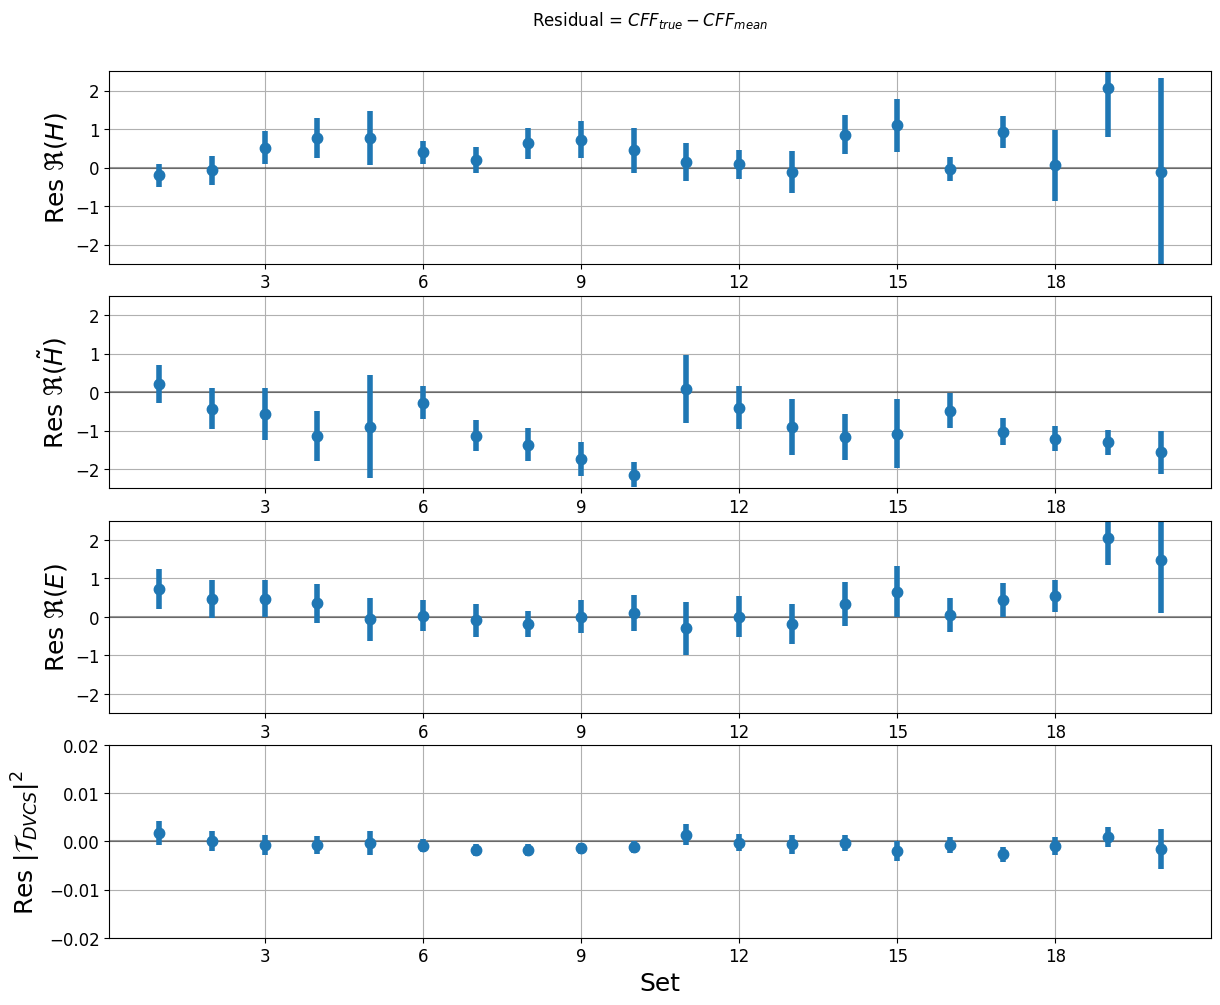

In [42]:
def residuals(res_dir, df, set_id, ax):

    df_set = df[df['set'] == set_id]
    ReH, ReHt, ReE, DVCS = df_set[['ReH', 'ReHt', 'ReE', 'DVCS']].values[0]
    df_result = pd.read_parquet(f'{res_dir}/sample/set_{set_id}.parquet').dropna()
    ReH_pred, ReHt_pred, ReE_pred, DVCS_pred = (df_result[c].unique() for c in ['ReH_pred', 'ReHt_pred', 'ReE_pred', 'DVCS_pred'])

    ReH_mean, ReH_sigma = norm.fit(ReH_pred)
    ReHt_mean, ReHt_sigma = norm.fit(ReHt_pred)
    ReE_mean, ReE_sigma = norm.fit(ReE_pred)
    DVCS_mean, DVCS_sigma = norm.fit(DVCS_pred)
    
    ax[0].errorbar(set_id, ReH-ReH_mean, ReH_sigma, fmt='.', c='tab:blue', lw=4, ms=15)
    ax[1].errorbar(set_id, ReHt-ReHt_mean, ReHt_sigma, fmt='.', c='tab:blue', lw=4, ms=15)
    ax[2].errorbar(set_id, ReE-ReE_mean, ReE_sigma, fmt='.', c='tab:blue', lw=4, ms=15)
    ax[3].errorbar(set_id, DVCS-DVCS_mean, DVCS_sigma, fmt='.', c='tab:blue', lw=4, ms=15)

FIG, AX = plt.subplots(4,1, figsize = (12, 10))
FIG.suptitle('Residual = '+r'$CFF_{true}-CFF_{mean}$')
plt.subplots_adjust(left=0.1, right=0.95, top=0.95, bottom=0.1)
plt.tight_layout(pad=2, w_pad=2, h_pad=0.2)
for i in [0,1,2,3]:
    AX[i].axhline(0, c='k', alpha=0.4)
    AX[i].grid()
    AX[i].xaxis.set_major_locator(MaxNLocator(integer=True))
    AX[i].set_ylim([-2.5,2.5])
    AX[i].tick_params(axis='both', which='major', labelsize=12)
AX[3].set_xlabel('Set', fontsize=18)
AX[3].set_ylim([-0.02,0.02])

AX[0].set_ylabel(r'Res $\Re(H)$', fontsize=18)
AX[1].set_ylabel(r'Res $\Re(\tilde{H})$', fontsize=18)
AX[2].set_ylabel(r'Res $\Re(E)$', fontsize=18)
AX[3].set_ylabel(r'Res $|\mathcal{T}_{DVCS}|^2$', fontsize=18)


res_dir = 'data_1'

filename = 'pseudo_KM15_BKM10_Jlab_all_t2_8pars.csv'

df = pd.read_csv(filename, usecols=[0, 2, 3, 4, 5, 6, 7, 8, 10, 11, 12, 13, 14, 15, 16, 17, 18], skiprows=1,
                names=['set', 'k', 'Q2', 'x', 't', 'phi', 'dsig_exp', 'dsig_err',
                        'ReH', 'ReE', 'ReHt', 'ReEt', 'ImH', 'ImE', 'ImHt', 'ImEt', 'DVCS'])
df = df[df['dsig_exp'] > 0]

for i in range(20):
    residuals(res_dir, df, i+1, AX)

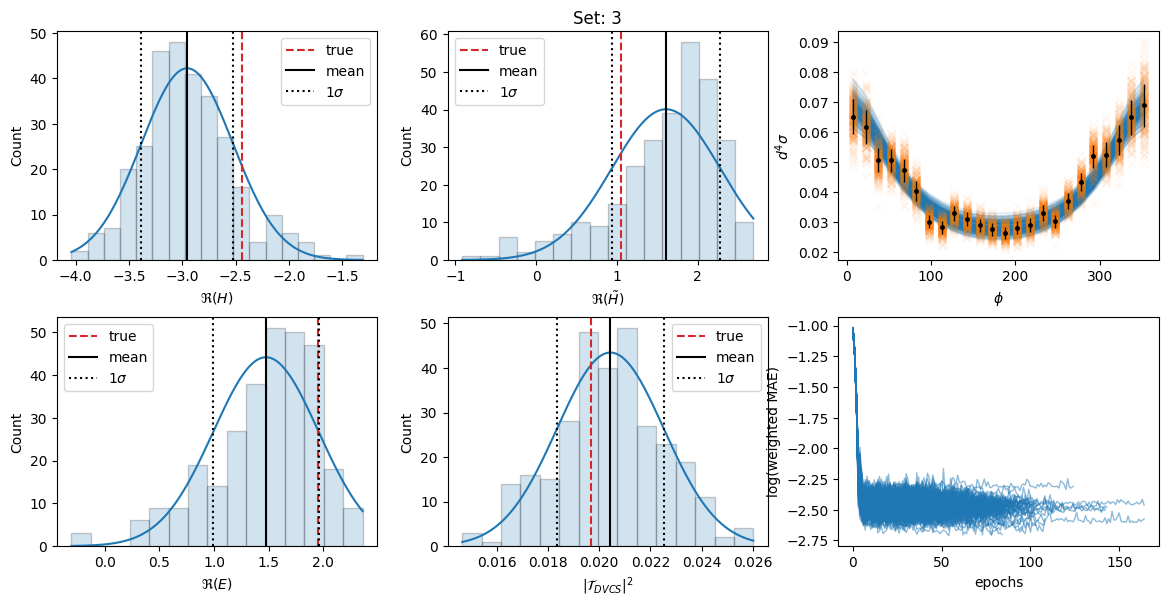

In [43]:
fig, ax = plt.subplots(2, 3, figsize=(12, 6))
plt.tight_layout(pad=2, w_pad=2, h_pad=2)

analysis(res_dir, df, 3, fig, ax)